In [10]:
!pip install pysyncon

In [11]:
# Package imports for data analysis and manipulation
import numpy as np
import pandas as pd

# Synthetic control module by Stiofáin Fordham
from pysyncon import *

# Visualisation
import matplotlib.pyplot as plt


In [12]:
# Set display options for Pandas to view all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def iea_import1(filepath):
    """
    Imports CO2 per capita data from a CSV file sourced from the IEA.

    Parameters:
    filepath (str): The path to the CSV file.

    Returns:
    pd.DataFrame: A DataFrame containing CO2 per capita data, indexed by years.
    """
    data = pd.read_csv(filepath, sep=',', skiprows=3, engine='python', index_col=0)
    data = data.iloc[:, :-1]  # Exclude the last column
    data.index.name = 'Years'
    return data


def iea_import2(filepath):
    """
    Imports CO2 emissions for the industry sector from a CSV file sourced from the IEA.

    Parameters:
    filepath (str): The path to the CSV file.

    Returns:
    pd.DataFrame: A DataFrame containing CO2 emissions for the industry sector, indexed by years.
    """
    data = pd.read_csv(filepath, sep=',', skiprows=3, engine='python', index_col=0, usecols=['Unnamed: 0', 'Industry'])
    data = data.rename(columns={'Industry': 'CO2 emissions for Industry sector (Mt CO2)'})
    return data


def iea_import3(filepath):
    """
    Imports electricity consumption for the industry sector from a CSV file sourced from the IEA.

    Parameters:
    filepath (str): The path to the CSV file.

    Returns:
    pd.DataFrame: A DataFrame containing electricity consumption for the industry sector, indexed by years.
    """
    data = pd.read_csv(filepath, sep=',', skiprows=3, engine='python', index_col=0, usecols=['Unnamed: 0', 'Industry'])
    data = data.rename(columns={'Industry': 'Electricity consumption for Industry sector (TJ)'})
    return data


def wb_import(filepath):
    """
    Imports World Bank data and transposes the dataset to make it more readable.
    Handles missing values and converts relevant columns.

    Parameters:
    filepath (str): The path to the CSV file.

    Returns:
    pd.DataFrame: A transposed DataFrame containing relevant World Bank data, indexed by years.
    """
    data = pd.read_csv(filepath)
    data = data.replace('..', np.nan)  # Replace missing values with NaN
    data_transposed = data.transpose()  # Transpose data for easier access
    data_transposed = data_transposed.iloc[:, :-5]  # Remove the last 5 columns
    data_transposed = data_transposed.drop(['Country Name', 'Country Code', 'Series Code'])
    
    # Clean up the index to remove 'YR' and convert to integers
    data_transposed.index = data_transposed.index.map(lambda x: x.split(' ')[0] if 'YR' in x else x)
    
    if 'Series Name' in data_transposed.index:
        data_transposed = data_transposed.drop('Series Name')
    
    # Attempt to convert index to integer
    try:
        data_transposed.index = data_transposed.index.astype(int)
    except ValueError:
        # Handle the case where index conversion to int is not straightforward
        print("Index contains non-integer values that could not be converted.")
    
    data_transposed.index.name = 'Years'
    
    # Rename columns for better readability
    data_transposed.columns = [
        'Industry (including construction), value added (% of GDP)',
        'GDP per capita, PPP (constant 2017 international $)',
        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
        'Renewable energy consumption (% of total final energy consumption)'
    ]

    return data_transposed


def combine_data(filepath1, filepath2, filepath3, filepath4):
    """
    Combines data from multiple sources (World Bank, IEA) into a single DataFrame.

    Parameters:
    filepath1 (str): Path to the World Bank data.
    filepath2 (str): Path to the CO2 per capita data (IEA).
    filepath3 (str): Path to the CO2 emissions for industry data (IEA).
    filepath4 (str): Path to the electricity consumption data (IEA).

    Returns:
    pd.DataFrame: A combined DataFrame containing all predictors and outcomes.
    """
    predictors = wb_import(filepath1)
    co2_percapita = iea_import1(filepath2)
    co2_industry = iea_import2(filepath3)
    elec_consumption = iea_import3(filepath4)
    
    # Combine all data into one DataFrame
    combined = pd.concat([predictors, co2_percapita, co2_industry, elec_consumption], axis=1, join='inner')

    return combined

In [19]:
# Base path where all CSV files are located
base_path = "../data/"

# Define file paths for each country using relative paths
countries = {
    'Ukraine': {
        'predictor': f"{base_path}Ukraine Predictors.csv",
        'co2_per_capita': f"{base_path}CO2 emissions per capita - Ukraine.csv",
        'co2_industry': f"{base_path}CO2 emissions by sector - Ukraine.csv",
        'electricity': f"{base_path}Electricity consumption by sector - Ukraine.csv"
    },
    'Indonesia': {
        'predictor': f"{base_path}Indonesia Predictors.csv",
        'co2_per_capita': f"{base_path}CO2 emissions per capita - Indonesia.csv",
        'co2_industry': f"{base_path}CO2 emissions by sector - Indonesia.csv",
        'electricity': f"{base_path}Electricity consumption by sector - Indonesia.csv"
    },
    'Turkey': {
        'predictor': f"{base_path}Turkey Predictors.csv",
        'co2_per_capita': f"{base_path}CO2 emissions per capita - Republic of Turkiye.csv",
        'co2_industry': f"{base_path}CO2 emissions by sector - Republic of Turkiye.csv",
        'electricity': f"{base_path}Electricity consumption by sector - Republic of Turkiye.csv"
    },
    # Add remaining countries following the same pattern
}

# Example of loading data for Ukraine
ukraine_data = pd.read_csv(countries['Ukraine']['predictor'])



In [21]:
# Create an empty dictionary to store the combined dataframes for each country
combined_dataframes = {}

# Loop through the dictionary and process each country's data
for country_name, file_paths in countries.items():
    # Call the combine_data function for each country
    combined_data = combine_data(
        file_paths['predictor'],
        file_paths['co2_per_capita'],
        file_paths['co2_industry'],
        file_paths['electricity']
    )
    # Add the 'Country' column to the combined dataframe
    combined_data['Country'] = country_name
    # Store the dataframe in the dictionary with the country's name
    combined_dataframes[f"{country_name.lower()}_combined"] = combined_data

# Combine all the countries into a single dataframe
# You can exclude specific countries by modifying the list in the `concat()` call
all_countries_combined = pd.concat(combined_dataframes.values(), ignore_index=False)

# Set index name and reset the index for the combined dataframe
all_countries_combined.index.name = 'Years'
all_countries_combined = all_countries_combined.reset_index()

# Filter the dataframe to include only years from 1995 onwards
all_countries_combined = all_countries_combined.query("Years >= 1995")

# Print the first 10 rows of the combined dataframe
print(all_countries_combined.head(10))

    Years Industry (including construction), value added (% of GDP)  \
5    1995                                   38.1638229362823          
6    1996                                   33.7810817110122          
7    1997                                   30.4803727306807          
8    1998                                   30.6287953369138          
9    1999                                   32.0180616672544          
10   2000                                          31.650277          
11   2001                                          29.907896          
12   2002                                          30.215514          
13   2003                                          30.426709          
14   2004                                           29.37177          

   GDP per capita, PPP (constant 2017 international $)  \
5                                       7906.95703125    
6                                      7179.677734375    
7                                    7028.04

In [23]:
# Getting average CO2 for all countries excluding Ukraine
df_without_ukraine = all_countries_combined.loc[all_countries_combined['Country'] != 'Ukraine'].copy()

# Ensure 'Years' is converted to integer
df_without_ukraine['Years'] = df_without_ukraine['Years'].astype(int)

# Calculate the average CO2 per capita for all countries except Ukraine
average_co2_per_capita = df_without_ukraine.groupby('Years')['CO2/population'].mean()

# Filter the years from 1995 onwards
average_co2_per_capita = average_co2_per_capita.loc[average_co2_per_capita.index >= 1995]

# Display the result
average_co2_per_capita


Years
1995    4.595067
1996    4.585200
1997    4.654133
1998    4.593333
1999    4.391800
2000    4.638600
2001    4.698333
2002    4.818933
2003    5.000067
2004    5.207867
2005    5.263467
2006    5.491933
2007    5.624533
2008    5.920667
2009    5.551467
2010    5.814333
2011    5.976267
2012    5.994467
2013    5.985133
2014    5.672200
2015    5.546667
2016    5.618333
2017    5.743067
2018    5.768400
2019    5.920222
Name: CO2/population, dtype: float64

In [27]:
# PySynCon Estimation
from pysyncon.utils import PlaceboTest

# Preparing the dataframe to create a dataprep object using PySynCon
df = all_countries_combined
columns_to_convert = [
    "Industry (including construction), value added (% of GDP)",
    "GDP per capita, PPP (constant 2017 international $)",
    "Energy intensity level of primary energy (MJ/$2017 PPP GDP)",
    "Renewable energy consumption (% of total final energy consumption)",
    "CO2/population"
]
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')


# Dataprep function from pysyncon package to setup synthetic control
dataprep = Dataprep(
    foo=df,
    predictors=['Industry (including construction), value added (% of GDP)',
       'GDP per capita, PPP (constant 2017 international $)',
       'Electricity consumption for Industry sector (TJ)',
        'CO2/population',
        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
        'Renewable energy consumption (% of total final energy consumption)'],
    predictors_op="mean",
    time_predictors_prior=range(1995, 2011),
    dependent="CO2/population",
    unit_variable="Country",
    time_variable="Years",
    treatment_identifier="Ukraine",
    controls_identifier=["Indonesia", "Turkey", "Malaysia",
                        "South Africa", "Brazil", "Israel",
                        "Russia", "Belarus", "Egypt", "Azerbaijan", "Bosnia", "Serbia", "Iran", "Iraq",
                        "Kazakhstan"],
    time_optimize_ssr=range(1995, 2018),
)



In [28]:
# Fit Ridge Augmented Synthetic Control Method
aug_scm = AugSynth()
aug_scm.fit(dataprep, lambda_= 0.1)

In [29]:
# View individual country weighting in the synthetic control model
print(aug_scm.weights())

Indonesia      -0.272
Turkey         -1.059
Malaysia       -0.366
South Africa   -0.045
Brazil          0.495
Israel          0.399
Russia          0.118
Belarus         0.344
Egypt           0.590
Azerbaijan      0.840
Bosnia         -0.106
Serbia          0.107
Iran            0.008
Iraq           -0.202
Kazakhstan      0.149
Name: weights, dtype: float64


In [30]:
# View the predictots of the treated unit against the synthetic unit and the mean of the donor group
print(aug_scm.summary())

                                                       treated   synthetic  \
Industry (including construction), value added ...      30.408      30.485   
GDP per capita, PPP (constant 2017 internationa...    9732.766    9664.702   
Electricity consumption for Industry sector (TJ)    227724.500  224668.715   
CO2/population                                           6.336       6.341   
Energy intensity level of primary energy (MJ/$2...      11.354      11.292   
Renewable energy consumption (% of total final ...       1.601       1.758   

                                                    sample mean  
Industry (including construction), value added ...       35.740  
GDP per capita, PPP (constant 2017 internationa...    12612.384  
Electricity consumption for Industry sector (TJ)     205655.229  
CO2/population                                            5.053  
Energy intensity level of primary energy (MJ/$2...        6.535  
Renewable energy consumption (% of total final ...       

In [31]:
# Compute average effect of treatment on treated and its accompanying standard error
att_result = aug_scm.att(time_period=range(2011, 2018))
print("ATT:", att_result)

ATT: {'att': -0.013747239579549486, 'se': 0.10046193205125421}


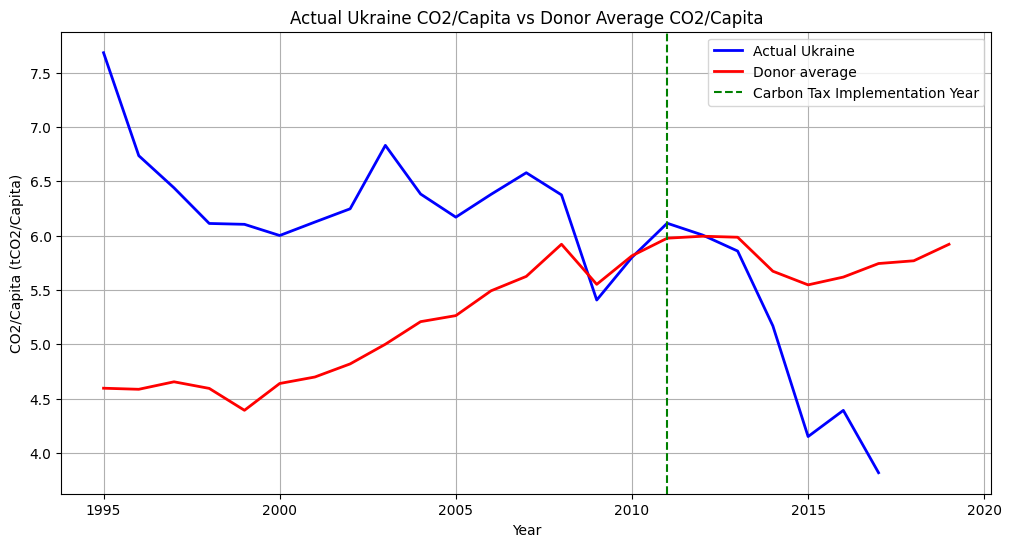

In [32]:
# Manual plotting code
Z0, Z1 = dataprep.make_outcome_mats(time_period=range(1995, 2018))
ts_synthetic = Z0.dot(aug_scm.W)  #unpack synth ts
ts_actual = Z1  #unpack actual ts
ts_synthetic.to_numpy()
ts_actual.to_numpy()

# Path plot: average vs actual
plt.figure(figsize=(12, 6))
plt.plot(ts_actual.index, ts_actual, label='Actual Ukraine', color='blue', linewidth=2)
plt.plot(average_co2_per_capita.index, average_co2_per_capita, label = 'Donor average', color ='red', linewidth=2)
plt.axvline(x=2011, color='green', linestyle='--', label='Carbon Tax Implementation Year')
plt.xlabel('Year')
plt.ylabel('CO2/Capita (tCO2/Capita)')
plt.title('Actual Ukraine CO2/Capita vs Donor Average CO2/Capita')
plt.legend()
plt.grid(True)
plt.show()

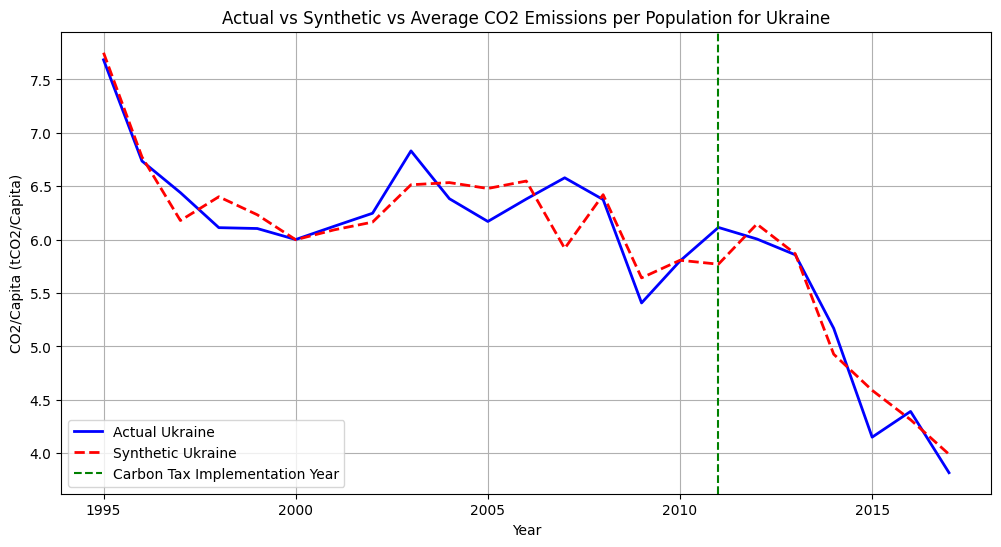

In [33]:
# Path plot: actual vs synth
plt.figure(figsize=(12, 6))
plt.plot(ts_actual.index, ts_actual, label='Actual Ukraine', color='blue', linewidth=2)
plt.plot(ts_synthetic.index, ts_synthetic, label='Synthetic Ukraine', linestyle='--', color='red', linewidth=2)
plt.axvline(x=2011, color='green', linestyle='--', label='Carbon Tax Implementation Year')
plt.xlabel('Year')
plt.ylabel('CO2/Capita (tCO2/Capita)')
plt.title('Actual vs Synthetic vs Average CO2 Emissions per Population for Ukraine')
plt.legend()
plt.grid(True)
plt.show()

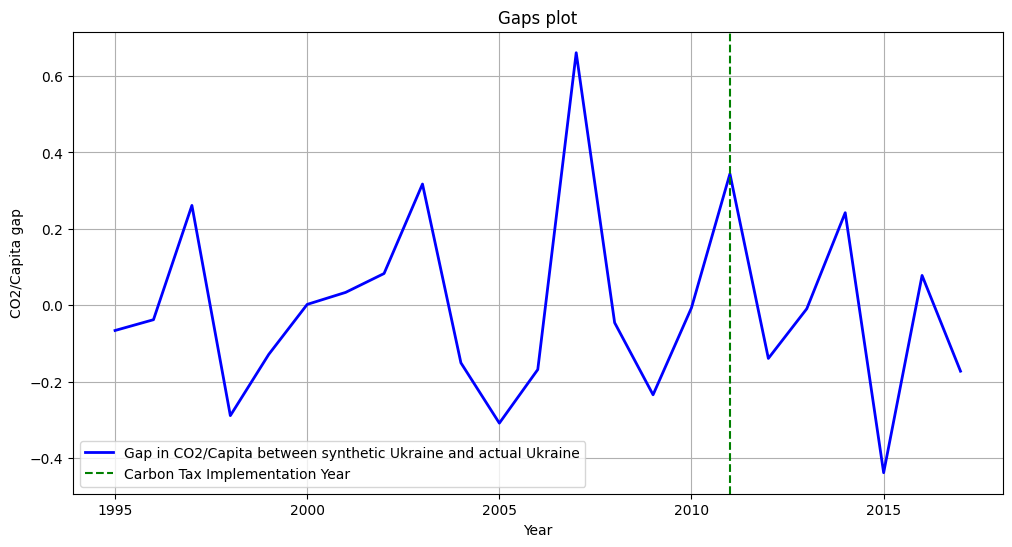

In [34]:
# Gaps plot
ts_gaps = ts_actual - ts_synthetic # Calculate gap for every period
plt.figure(figsize=(12, 6))
plt.plot(ts_gaps.index, ts_gaps, label = 'Gap in CO2/Capita between synthetic Ukraine and actual Ukraine', color = 'blue', linewidth =2)
plt.axvline(x=2011, color='green', linestyle='--', label='Carbon Tax Implementation Year')
plt.xlabel('Year')
plt.ylabel('CO2/Capita gap')
plt.title('Gaps plot')
plt.legend()
plt.grid(True)
plt.show()

/Users/athaaan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/athaaan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/athaaan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/athaaan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed

(1/15) Completed placebo test for Indonesia.
(2/15) Completed placebo test for Russia.
(3/15) Completed placebo test for Malaysia.
(4/15) Completed placebo test for Israel.
(5/15) Completed placebo test for Bosnia.
(6/15) Completed placebo test for South Africa.
(7/15) Completed placebo test for Brazil.
(8/15) Completed placebo test for Turkey.
(9/15) Completed placebo test for Azerbaijan.
(10/15) Completed placebo test for Egypt.
(11/15) Completed placebo test for Serbia.
(12/15) Completed placebo test for Belarus.
(13/15) Completed placebo test for Iraq.
(14/15) Completed placebo test for Kazakhstan.
(15/15) Completed placebo test for Iran.
Calculating treated unit gaps.
Done.


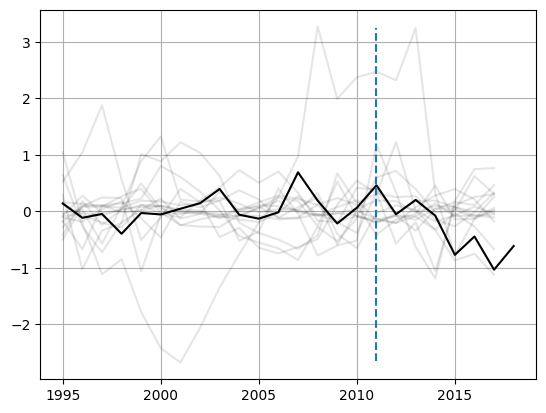

In [35]:
#Robustness checks part 1: In-place placebo checks
placebo_test = PlaceboTest()
placebo_test.fit(dataprep=dataprep, scm=aug_scm)
placebo_test.gaps_plot(time_period=range(1995, 2018), treatment_time=2011)

In [39]:
# Robustness checks part 2: LOOCV/Leave One Out Cross Validation

def loocv_synthetic_series(dataprep, scm_class, controls, lambda_value=0.1):
    """
    Performs Leave One Out Cross Validation (LOOCV) for the synthetic control method.

    Parameters:
    -----------
    dataprep : Dataprep
        The data preparation object used to structure the input data.
    scm_class : class
        The synthetic control class used to fit the model (e.g., Augmented Synthetic Control).
    controls : list
        A list of countries used as controls in the synthetic control method.
    lambda_value : float, optional, default=0.1
        The regularization parameter used in the synthetic control method.

    Returns:
    --------
    pd.DataFrame
        A DataFrame containing synthetic time series for each control country, with countries as columns
        and years as index.
    """

    # Initialize an empty DataFrame to store synthetic series for each control country
    synthetic_series_df = pd.DataFrame()

    # Loop through each country in the control list for the Leave-One-Out Cross Validation
    for country in controls:
        # Exclude the current country from the control group
        controls_without_country = [c for c in controls if c != country]

        # Prepare the data for the synthetic control method, excluding the current country
        dataprep_loocv = Dataprep(
            foo=df,  # Data source (replace 'df' with the actual DataFrame if necessary)
            predictors=[
                'Industry (including construction), value added (% of GDP)',
                'GDP per capita, PPP (constant 2017 international $)',
                'Electricity consumption for Industry sector (TJ)',
                'CO2/population',
                'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                'Renewable energy consumption (% of total final energy consumption)'
            ],
            predictors_op="mean",  # Operation to summarize predictors (mean of predictors)
            time_predictors_prior=range(1995, 2011),  # Time period before the treatment (pre-treatment)
            dependent="CO2/population",  # The outcome variable of interest
            unit_variable="Country",  # The unit (country) variable
            time_variable="Years",  # The time period variable
            treatment_identifier="Ukraine",  # The treated country
            controls_identifier=controls_without_country,  # Control countries excluding the current one
            time_optimize_ssr=range(1995, 2018),  # Time period for optimizing sum of squared residuals
        )

        # Initialize the synthetic control model class and fit the model
        aug_synth_loocv = scm_class()
        aug_synth_loocv.fit(dataprep_loocv, lambda_=lambda_value)

        # Generate outcome matrices (synthetic time series) using the fitted model
        Z2, _ = dataprep_loocv.make_outcome_mats(time_period=range(1995, 2018))
        ts_synthetic_loocv = Z2.dot(aug_synth_loocv.W)  # Compute synthetic outcome

        # Add the synthetic time series to the DataFrame with the country name as the column
        synthetic_series_df[country] = ts_synthetic_loocv.squeeze()

    # Return the DataFrame containing synthetic time series for each control country
    return synthetic_series_df


# List of control countries to be used in the synthetic control method
controls_list = ["Indonesia", "Turkey", "Malaysia",
                 "South Africa", "Brazil", "Israel",
                 "Russia", "Belarus", "Egypt", "Azerbaijan", "Bosnia", "Serbia", "Iran", "Iraq",
                 "Kazakhstan"]

# Perform LOOCV using the defined list of control countries and store the results in a DataFrame
loocv_results_df = loocv_synthetic_series(dataprep, AugSynth, controls_list)

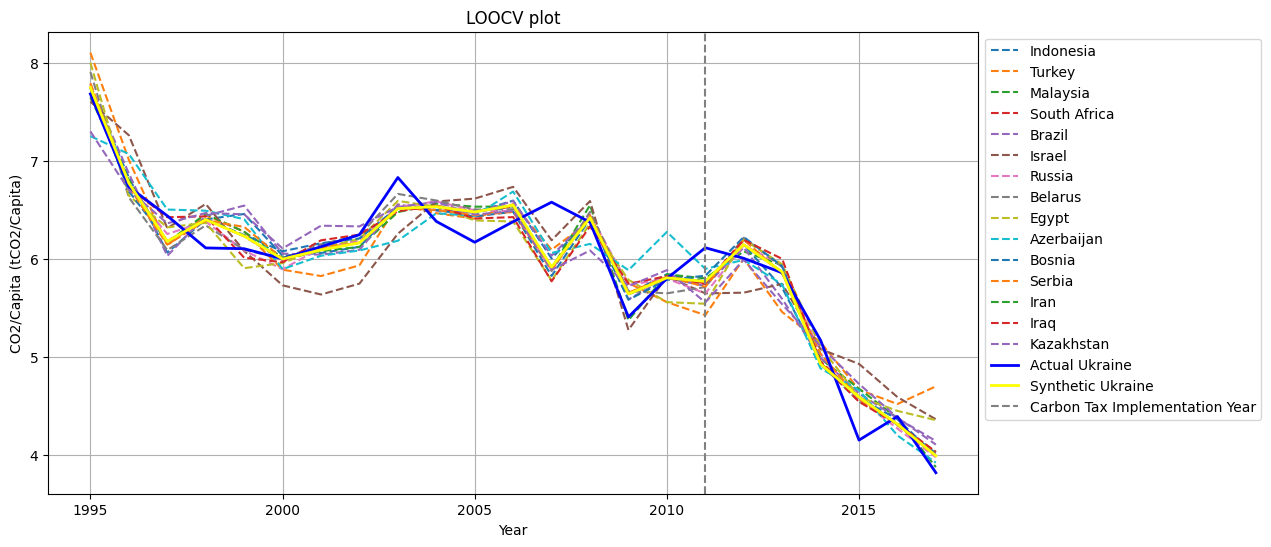

In [40]:
# LOOCV plotting code
plt.figure(figsize=(12, 6))
for column in loocv_results_df.columns:
    plt.plot(loocv_results_df.index, loocv_results_df[column], label=column, linestyle = '--')
plt.plot(ts_actual.index, ts_actual, label='Actual Ukraine', color='blue', linewidth=2)
plt.plot(ts_synthetic.index, ts_synthetic, label='Synthetic Ukraine', color='yellow', linewidth=2)
plt.axvline(x=2011, color='grey', linestyle='--', label='Carbon Tax Implementation Year')
plt.xlabel('Year')
plt.ylabel('CO2/Capita (tCO2/Capita)')
plt.title('LOOCV plot')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()


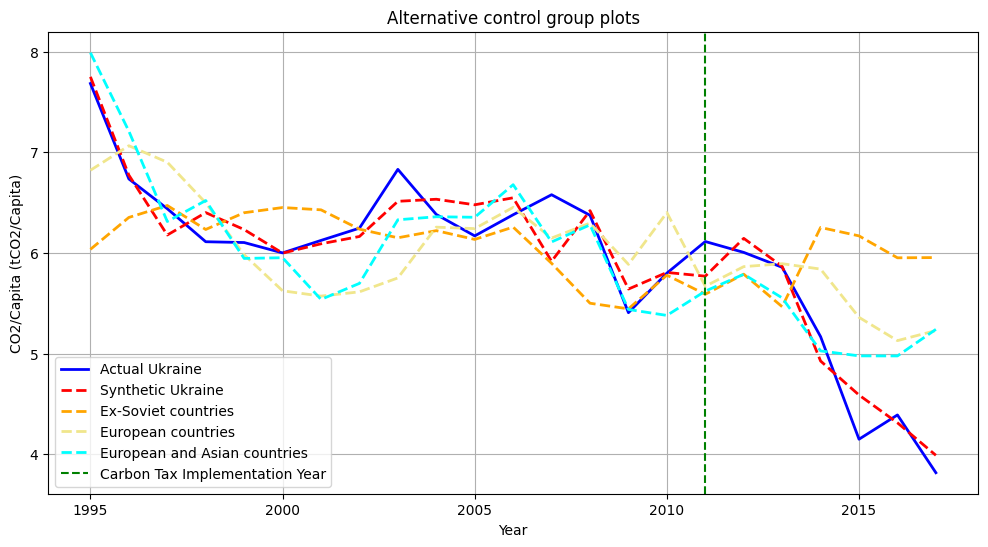

In [46]:
#Robustness checks part 3: Alternative sample group checks

# Create a dataprep object for ex-Soviet countries sample
dataprep_sov = Dataprep(
    foo=df,
    predictors=['Industry (including construction), value added (% of GDP)',
       'GDP per capita, PPP (constant 2017 international $)',
       'Electricity consumption for Industry sector (TJ)',
        "CO2/population",
        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
        'Renewable energy consumption (% of total final energy consumption)'],
    predictors_op="mean",
    time_predictors_prior=range(1995, 2011),  # before the implementation of the carbon tax
    dependent="CO2/population",
    unit_variable="Country",
    time_variable="Years",
    treatment_identifier="Ukraine",
    controls_identifier=[ "Russia", "Belarus", "Azerbaijan",
                        "Kazakhstan"],
    time_optimize_ssr=range(1995, 2018),
)

# Fit ridge-augmented scm
aug_scm_sov = AugSynth()
aug_scm_sov.fit(dataprep_sov, lambda_= 0.1)

#average effect of treatment on treated
#att_result_sov = aug_scm_sov.att(time_period=range(2011, 2018))
#print("ATT:", att_result_sov)

# Deriving series
Z2, _ = dataprep_sov.make_outcome_mats(time_period=range(1995, 2018))
ts_synthetic_sov = Z2.dot(aug_scm_sov.W)  # unpack synth ts
ts_synthetic_sov.to_numpy()

# Create a dataprep object for European countries sample
dataprep_euro = Dataprep(
    foo=df,
    predictors=['Industry (including construction), value added (% of GDP)',
       'GDP per capita, PPP (constant 2017 international $)',
       'Electricity consumption for Industry sector (TJ)',
        "CO2/population",
        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
        'Renewable energy consumption (% of total final energy consumption)'],
    predictors_op="mean",
    time_predictors_prior=range(1995, 2011),  #before the implementation of the carbon tax
    dependent="CO2/population",
    unit_variable="Country",
    time_variable="Years",
    treatment_identifier="Ukraine",
    controls_identifier=["Russia", "Belarus", "Azerbaijan", "Bosnia", "Serbia"],
    time_optimize_ssr=range(1995, 2018),
)

# Fit ridge-augmented scm
aug_scm_euro = AugSynth()
aug_scm_euro.fit(dataprep_euro, lambda_= 0.1)


# Deriving series
Z3, _ = dataprep_euro.make_outcome_mats(time_period=range(1995, 2018))
ts_synthetic_euro = Z3.dot(aug_scm_euro.W)  #unpack synth ts
ts_synthetic_euro.to_numpy()

# Create a dataprep object for European and Asian countries sample
dataprep_euroAs = Dataprep(
    foo=df,
    predictors=['Industry (including construction), value added (% of GDP)',
       'GDP per capita, PPP (constant 2017 international $)',
       'Electricity consumption for Industry sector (TJ)',
        "CO2/population",
        'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
        'Renewable energy consumption (% of total final energy consumption)'],
    predictors_op="mean",
    time_predictors_prior=range(1995, 2011),
    dependent="CO2/population",
    unit_variable="Country",
    time_variable="Years",
    treatment_identifier="Ukraine",
    controls_identifier=["Turkey",
                        "Russia", "Belarus", "Azerbaijan", "Bosnia", "Serbia",
                        "Kazakhstan","Iran", "Iraq", "Malaysia", "Indonesia"],
    time_optimize_ssr=range(1995, 2018),
)

# Fit ridge-augmented scm
aug_scm_euroAs = AugSynth()
aug_scm_euroAs.fit(dataprep_euroAs, lambda_= 0.1)

# Deriving series
Z4, _ = dataprep_euroAs.make_outcome_mats(time_period=range(1995, 2018))
ts_synthetic_euroAs = Z4.dot(aug_scm_euroAs.W)  #unpack synth ts
ts_synthetic_euroAs.to_numpy()

# Path plot: actual vs synth of various control groups
plt.figure(figsize=(12, 6))
plt.plot(ts_actual.index, ts_actual, label='Actual Ukraine', color='blue', linewidth=2)
plt.plot(ts_synthetic.index, ts_synthetic, label='Synthetic Ukraine', linestyle='--', color='red', linewidth=2)
plt.plot(ts_synthetic_sov.index, ts_synthetic_sov, label='Ex-Soviet countries', linestyle='--', color='orange', linewidth=2)
plt.plot(ts_synthetic_euro.index, ts_synthetic_euro, label='European countries', linestyle='--', color='khaki', linewidth=2)
plt.plot(ts_synthetic_euroAs.index, ts_synthetic_euroAs, label='European and Asian countries', linestyle='--', color='cyan', linewidth=2)
plt.axvline(x=2011, color='green', linestyle='--', label='Carbon Tax Implementation Year')
plt.xlabel('Year')
plt.ylabel('CO2/Capita (tCO2/Capita)')
plt.title('Alternative control group plots')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Country weights for full sample
print(aug_scm.weights())

Indonesia      -0.107
Turkey         -0.308
Malaysia       -0.424
South Africa    0.207
Brazil          0.119
Israel          0.246
Russia          0.124
Belarus         0.401
Egypt           0.204
Azerbaijan      0.704
Bosnia         -0.105
Serbia          0.061
Iran           -0.094
Iraq           -0.079
Kazakhstan      0.050
Name: weights, dtype: float64


In [43]:
# Country weights for ex-Soviet sample
print(aug_scm_sov.weights())

Russia        0.419
Belarus       0.788
Azerbaijan    0.077
Kazakhstan   -0.284
Name: weights, dtype: float64


In [44]:
# Country weights for European sample
print(aug_scm_euro.weights())

Russia       -0.096
Belarus       1.368
Azerbaijan   -0.053
Bosnia       -0.391
Serbia        0.172
Name: weights, dtype: float64


In [45]:
#region weights
print(aug_scm_euroAs.weights())

Turkey        0.317
Russia        0.177
Belarus       0.497
Azerbaijan    0.921
Bosnia       -0.355
Serbia        0.305
Kazakhstan    0.140
Iran         -0.128
Iraq         -0.291
Malaysia     -0.491
Indonesia    -0.091
Name: weights, dtype: float64
